In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-vs-real-face-classification/Validation/fake/623.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/537.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/654.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/539.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/708.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/646.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/682.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/544.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/576.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/613.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/703.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/717.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/626.jpg
/kaggle/input/fake-vs-real-face-classification/Validation/fake/732.jpg
/kaggl

In [2]:
#Importing necessary libraries
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-18 13:48:20.598866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 13:48:20.599022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 13:48:20.747796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#This will ignore the warnings that will be generated by the code
import warnings
warnings.filterwarnings('ignore')

In [4]:
#defines the desired shape for the images
IMAGE_SHAPE = (224, 224)

#These variables store the paths to the directories containing the training, validation, and test image data respectively.
train_dir = "/kaggle/input/fake-vs-real-face-classification/train"
valid_dir = "/kaggle/input/fake-vs-real-face-classification/Validation"
test_dir='/kaggle/input/fake-vs-real-face-classification/test'

#These are instances of the ImageDataGenerator class from Keras, which is used for data augmentation and preprocessing of image data. 
#configured to rescale the pixel values of images to the range [0,1].
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#These are generators created using the flow_from_directory method of ImageDataGenerator. 
#They generate batches of preprocessed images and their corresponding labels on the fly from the directories specified.
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SHAPE,
    class_mode="categorical",
    batch_size=32
)

valid_data = validation_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=IMAGE_SHAPE,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=1,
    shuffle=False
)


Found 1197 images belonging to 2 classes.
Found 512 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [5]:
#This tells us about the number of classes of our data set
#Test_data doesnt have classes
print(train_data.class_indices)
print(valid_data.class_indices)


{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


In [6]:
#: This is a Keras model that allows stacking layers sequentially
from tensorflow.keras.models import Sequential
#: These are layer types provided by Keras for convolutional neural networks (CNNs).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,BatchNormalization


# Define your model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters, each with a size of 3x3, ReLU activation function, and input shape of (224, 224, 3) representing images of size 224x224 pixels with 3 channels (RGB).
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # Max pooling layer with a pool size of 2x2.
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer with 64 filters, each with a size of 3x3, using ReLU activation function.
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # Another max pooling layer with a pool size of 2x2.
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),  # Another convolutional layer with 128 filters, each with a size of 3x3, using ReLU activation function.
    BatchNormalization(),
    MaxPooling2D((2, 2)),  # Another max pooling layer with a pool size of 2x2.
    Dropout(0.25),
    Flatten(),  # Flattens the output from the previous layer into a one-dimensional tensor.
    Dense(128, activation='relu'),  # Fully connected (dense) layer with 128 neurons and ReLU activation function.
    BatchNormalization(),
    Dropout(0.25),
    Dense(2, activation='softmax')  # Output layer with 2 neurons, representing the two classes (fake vs. real), using softmax activation function to output class probabilities.
])
#The overall structure of the model consists of convolutional layers followed by max pooling layers to extract features from the input images, followed by fully connected layers for classification.

In [7]:
# Compile the model
model.compile(
    optimizer='adam',  # Optimizer used for training the model. Here, 'adam' is an adaptive learning rate optimization algorithm.
    loss='categorical_crossentropy',  # Loss function used for optimization. 'categorical_crossentropy' is commonly used for multi-class classification tasks.
    metrics=['accuracy']  # Metrics to evaluate the model during training. Here, 'accuracy' is used to monitor the classification accuracy.
)
'''
This compile function is a crucial step in preparing the model for training. It configures the model for training by specifying the optimizer, loss function, and metrics to be used.
optimizer='adam': The Adam optimizer is chosen for optimizing the model's weights during training. Adam is a popular choice due to its adaptive learning rate capabilities.
loss='categorical_crossentropy': This is the loss function used to measure the difference between the true labels and the predictions made by the model during training. For multi-class classification tasks with one-hot encoded labels, categorical crossentropy is commonly used.
metrics=['accuracy']: During training, the model's performance is evaluated using accuracy, which measures the proportion of correctly classified images out of the total number of images.
'''


"\nThis compile function is a crucial step in preparing the model for training. It configures the model for training by specifying the optimizer, loss function, and metrics to be used.\noptimizer='adam': The Adam optimizer is chosen for optimizing the model's weights during training. Adam is a popular choice due to its adaptive learning rate capabilities.\nloss='categorical_crossentropy': This is the loss function used to measure the difference between the true labels and the predictions made by the model during training. For multi-class classification tasks with one-hot encoded labels, categorical crossentropy is commonly used.\nmetrics=['accuracy']: During training, the model's performance is evaluated using accuracy, which measures the proportion of correctly classified images out of the total number of images.\n"

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)


In [9]:
# Train the model
history = model.fit(
    train_data,
    epochs=20,  # Specify the number of epochs you want to train for
    validation_data=valid_data,
    callbacks=[lr_scheduler]  # Include the learning rate scheduler here
)
'''
This fit function is used to train the model on the training data.
It iterates over the entire dataset for a specified number of epochs, 
updating the model's weights based on the optimization algorithm specified during compilation. 
The validation data is used to evaluate the model's performance after each epoch. 
The training progress is stored in the history object, which contains metrics such as loss and accuracy for both training and validation sets across epochs.
'''

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.4995 - loss: 1.5904 - val_accuracy: 0.5527 - val_loss: 5.8238 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5079 - loss: 0.9385 - val_accuracy: 0.5547 - val_loss: 1.4749 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5939 - loss: 0.7414 - val_accuracy: 0.5547 - val_loss: 1.5950 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5483 - loss: 0.7913 - val_accuracy: 0.5547 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.5689 - loss: 0.7644 - val_accuracy: 0.5566 - val_loss: 0.7874 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.5509 - loss: 0.7665 - val_accuracy: 0.5625 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5456 - loss: 0.7519 - val_acc

"\nThis fit function is used to train the model on the training data.\nIt iterates over the entire dataset for a specified number of epochs, \nupdating the model's weights based on the optimization algorithm specified during compilation. \nThe validation data is used to evaluate the model's performance after each epoch. \nThe training progress is stored in the history object, which contains metrics such as loss and accuracy for both training and validation sets across epochs.\n"

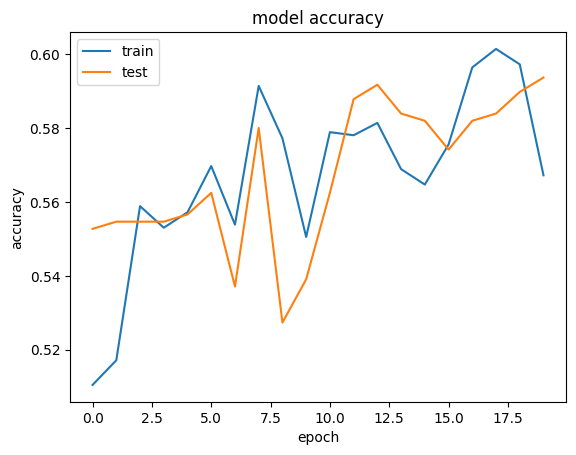

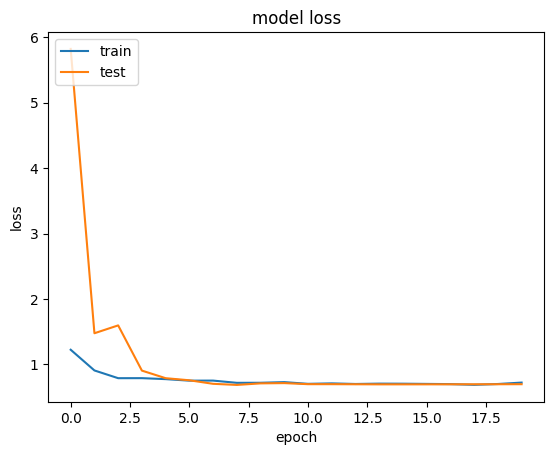

In [10]:
#This piece is used to visualize the model accuracy and model loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# checking the validation score of the model
loss, accuracy = model.evaluate(valid_data, steps=len(valid_data))
print(f'Validation accuracy: {accuracy}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 644ms/step - accuracy: 0.5855 - loss: 0.7058
Validation accuracy: 0.59375


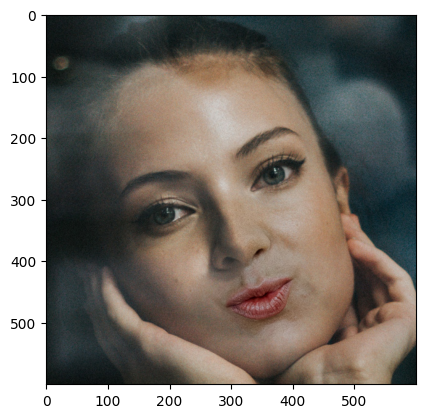

In [12]:
# Predict on test data
img = "/kaggle/input/fake-vs-real-face-classification/test/108.jpg"
plt.imshow(cv2.imread(img)[...,::-1])
plt.show()


In [13]:
# Read the image using OpenCV and convert it to RGB format
image = cv2.imread(img)[...,::-1]

# Resize the image to match the input shape of the model (224x224 pixels)
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

# Convert the pixel values of the image to float32 and normalize them to the range [0,1]
image = image.astype('float32')
image /= 255

# Reshape the image to match the input shape expected by the model (batch_size, height, width, channels)
image = image.reshape(1, 224, 224, 3)

# Predict the class probabilities for the image
predictions = model.predict(image)
print(predictions)

# Get the index of the class with the highest probability as the predicted class
predicted_class = np.argmax(predictions)
print(predicted_class)

'''
This segment loads an image, preprocesses it to match the input requirements of the model (resizing, normalization),
predicts its class probabilities using the trained model,
and prints both the probabilities and the predicted class index.
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[[0.5232963  0.47670367]]
0


'\nThis segment loads an image, preprocesses it to match the input requirements of the model (resizing, normalization),\npredicts its class probabilities using the trained model,\nand prints both the probabilities and the predicted class index.\n'

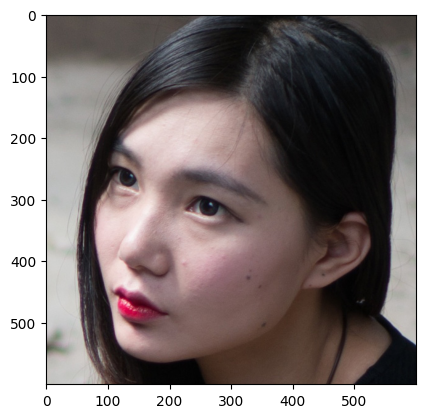

In [14]:
img2 = '/kaggle/input/fake-vs-real-face-classification/train/real/1003.jpg'
plt.imshow(cv2.imread(img2)[...,::-1])
plt.show()

In [15]:
image = cv2.imread(img2)[...,::-1]
image = cv2.resize(image, (224, 224),  interpolation = cv2.INTER_AREA)
image = image.astype('float32')
image /= 255

print(model.predict(image.reshape(1, 224, 224, 3)))
print(np.argmax(model.predict(image.reshape(1, 224, 224, 3))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.32687038 0.6731296 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1
